## TAA2: Natural Hazard Risk Assessment using Open Data

Within this tutorial, we are going to use publicly available hazard data and exposure data to do a risk assessment for the Netherlands. More specifically, we will look at damage due to wind storms and flooding. We will use both Copernicus Land Cover data and OpenStreetMap to estimate the potential damage of natural hazards to the built environment.

We will first download, access and explore hazard data retrieved from the Copernicus Climate Data Copernicus Store and the European Commission Joint Research Centre. We will also explore the power of OpenStreetMap that provides vector data. We will learn how to extract information from OpenStreetMap, how you can explore and visualize this. Lastly, we will use Copernicus Land Cover data to estimate the damage to specific land-uses, whereas we will use OpenStreetMap to assess the potential damage to the road system.

## Learning Objectives
<hr>

- To understand the use of **OSMnx** to extract geospatial data from OpenStreetmap.
- To know how to download data from the Copernicus Climate Data Store using the `cdsapi` and access it through Python.
- To know how to access and open information from the Copernicus Land Monitoring System. Specifically the Corine Land Cover data.

- To be able to open and visualize this hazard data.
- To know how to rasterize vector data through using **Geocube**.
- To know how to visualise vector and raster data.
- To understand the basic functioning of **Matplotlib** to create a map.

- To understand the basic approach of a natural hazard risk assessment.
- To be able to use the `DamageScanner` to do a damage assessment.
- To interpret and compare the damage estimates.

## 1. Introducing the packages
<hr>

Within this tutorial, we are going to make use of the following packages:

[**GeoPandas**](https://geopandas.org/) is a Python package that extends the datatypes used by pandas to allow spatial operations on geometric types.

[**OSMnx**](https://osmnx.readthedocs.io/) is a Python package that lets you download geospatial data from OpenStreetMap and model, project, visualize, and analyze real-world street networks and any other geospatial geometries. You can download and model walkable, drivable, or bikeable urban networks with a single line of Python code then easily analyze and visualize them. You can just as easily download and work with other infrastructure types, amenities/points of interest, building footprints, elevation data, street bearings/orientations, and speed/travel time.

[**NetworkX**](https://networkx.org/) is a Python package for the creation, manipulation, and study of the structure, dynamics, and functions of complex networks.

[**Matplotlib**](https://matplotlib.org/) is a comprehensive Python package for creating static, animated, and interactive visualizations in Python. Matplotlib makes easy things easy and hard things possible.

[**Geocube**](https://corteva.github.io/geocube) is a Python package to convert geopandas vector data into rasterized data.

[**xarray**](https://docs.xarray.dev/) is a Python package that allows for easy and efficient use of multi-dimensional arrays.

Import the packages in the cell below

In [2]:
import cdsapi
import shapely
import matplotlib
import urllib3
import pyproj
import contextily as cx

import osmnx as ox
import numpy as np
import xarray as xr
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import cdsapi

from matplotlib.colors import LinearSegmentedColormap,ListedColormap
from matplotlib.patches import Patch
from geocube.api.core import make_geocube
from zipfile import ZipFile
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile
from tqdm import tqdm

urllib3.disable_warnings()

Import error? Not all of the packages were installed already. Make sure to install the missing packages using pip install in the cell below and then run the cell above again:

In [ ]:
    !pip install cdsapi
    !pip install geocube
    !pip install contextily
    !pip install --pre osmnx
    !pip install 'cdsapi>=0.7.0'

## 2. Downloading and accessing natural hazard data
<hr>

We will first download and explore windstorm and flood data for the Netherlands.

### Windstorm Data
<hr>

The windstorm data will be downloaded from the [Copernicus Climate Data Store](https://cds.climate.copernicus.eu/). As we have seen during the lecture, and as you can also see by browsing on this website, there is an awful lot of climate data available through this Data Store. As such, it is very valuable to understand how to access and download this information to use within an analysis. To keep things simple, we only download one dataset today: [A winter windstorm](https://cds.climate.copernicus.eu/cdsapp#!/dataset/sis-european-wind-storm-indicators?tab=overview).

We will do so using an **API**, which is the acronym for application programming interface. It is a software intermediary that allows two applications to talk to each other. APIs are an accessible way to extract and share data within and across organizations. APIs are all around us. Every time you use a rideshare app, send a mobile payment, or change the thermostat temperature from your phone, you’re using an API.

However, before we can access this **API**, we need to take a few steps which can be found on the [CDSAPI setup webpage of the Copernicus Climate Data Store](https://cds-beta.climate.copernicus.eu/how-to-api/). The first step is to register yourself on the [Copernicus Climate Data Store](https://cds.climate.copernicus.eu/) portal. 

Now, the next step is to request access to the dataset. As you can see in the cell below, we download a specific windstorm that has occured on the 28th of October in 2013. This is storm [Carmen (also called St Jude)](https://en.wikipedia.org/wiki/St._Jude_storm). To download the relevant windstorm data, fill out the associated [dataset form](https://cds-beta.climate.copernicus.eu/datasets/sis-european-wind-storm-indicators?tab=download) and make sure to **agree to the Terms of Use**. 

The last step is to access the API. You can now login on the website of the [Copernicus Climate Data Store](https://cds.climate.copernicus.eu/). After you login, you can click on your name in the top right corner of the webpage (next to the login button). On the personal page that has just opened, you will find your personal access token **API**. You need to add this in the cell below to be able to download the windstorm.

In [ ]:
apikey = '' #add your personal API
 
c = cdsapi.Client(key=f"{apikey}", url="https://cds-beta.climate.copernicus.eu/api")
 
c.retrieve(
    'sis-european-wind-storm-indicators',
    {
        'variable': 'all',
        'format': 'zip',
        'product': 'windstorm_footprints',
        'year': '2013',
        'month': '10',
        'day': '28',
    },
    'Carmen.zip')

### Flood Data
<hr>

The flood data we will extract from a repository maintained by the European Commission Joint Research Centre. We will download river flood hazard maps from their [Flood Data Collection](https://data.jrc.ec.europa.eu/dataset/1d128b6c-a4ee-4858-9e34-6210707f3c81).

Here we do not need to use an API and we also do not need to register ourselves, so we can download any of the files directly. To do so, we use the `urllib` package.

In [4]:
## this is the link to the 1/100 flood map for Europe
zipurl = 'https://jeodpp.jrc.ec.europa.eu/ftp/jrc-opendata/FLOODS/EuropeanMaps/floodMap_RP100.zip'

# The path where the downloaded flood map will be extracted, this is the folder of this Google Collaboratory instance. NOTE: a new instance will have this directory be cleared.
data_path = ""

# and now we open and extract the data
with urlopen(zipurl) as zipresp:
    with ZipFile(BytesIO(zipresp.read())) as zfile:
        zfile.extractall(data_path)

The download and zip in the cell above sometimes does not work. If that is indeed the case (e.g., when it seems to remain stuck), download the files manually through the link and upload them in the data folder for this week (as explained at the start of this tutorial.)

### Set location to explore
---
Before we continue, we need to specify our location of interest. This should be a province that will have some flooding and relative high wind speeds occuring (else we will find zero damage). We specify the region of interest in the cell below by using the `geocode_to_gdf()` function.

In [5]:
place_name = "Kampen, The Netherlands"  ### But you could also consider a city in Zeeland, for example.
area = ox.geocode_to_gdf(place_name)

## 3. Exploring the natural hazard data
<hr>

### Windstorm Data
---

As you can see in the section above, we have downloaded the storm footprint in a zipfile. Let's open the zipfile and load the dataset using the `xarray` package through the `open_dataset()` function.

In [6]:
with ZipFile('Carmen.zip') as zf:

    # Let's get the filename first
    file = zf.namelist()[0]

    # And now we can open and select the file within Python
    with zf.open(file) as f:
        windstorm_europe = xr.open_dataset(f)

Let's have a look at the storm we have downloaded!

In [ ]:
windstorm_europe['FX'].plot()

<div class="alert alert-block alert-success">
<b>Question 1:</b> Describe windstorm Carmen. When did this event happen, which areas were most affected? Can you say something about the maximum wind speeds in different areas, based on the plot? And what does FX mean?
</div>

Unfortunately, our data does not have a proper coordinate system defined yet. As such, we will need to use the `rio.write_crs()` function to set the coordinate system to **EPSG:4326** (the standard global coordinate reference system).

We also need to make sure that the functions will know what the exact parameters are that we have to use for our spatial dimenions (e.g. longitude and latitude). It prefers to be named `x` and `y`. So we use the `rename()` function before we use the `set_spatial_dims()` function.

In [ ]:
windstorm_europe. #add CRS
windstorm_europe = windstorm_europe.rename({'Latitude': 'y','Longitude': 'x'})
windstorm_europe.rio.set_spatial_dims(x_dim="x",y_dim="y", inplace=True)

<div class="alert alert-block alert-success">
<b>Question 2:</b> Climate data is often stored as a netCDF file. Please describe what a netCDF file is. Which information is stored in the netCDF file we have downloaded for the windstorm? What type of metadata does it contain?
</div>

Following, we also make sure it will be in the European coordinate system **EPSG:3035** to ensure we can easily use it together with the other data. To do so, we use the `rio.reproject()` function. You can simple add the number of the coordinate system.

In [9]:
windstorm_europe = windstorm_europe. # add reproject

Now we have all the information to clip the windstorm data to our area of interest:

In [10]:
windstorm_map = windstorm_europe.rio.clip(area.envelope.values, area.crs)

And let's have a look as well by using the `plot()` function. Please note that the legend is in meters per second.

In [ ]:
windstorm_map['FX'] # add plot function

### Flood Data
---

And similarly, we want to open the flood map. But now we do not have to unzip the file anymore and we can directly open it through using `xarray`:

In [12]:
flood_map_path = 'floodmap_EFAS_RP100_C.tif'

In [ ]:
flood_map = xr.open_dataset(flood_map_path, engine="rasterio")
flood_map

And let's make sure we set all the variables and the CRS correctly again to be able to open the data properly. Note that we should now use **EPSG:3035**. This is the standard coordinate system for Europe, in meters (instead of degrees).

In [ ]:
flood_map.rio.write_crs(3035, inplace=True)
flood_map.rio.set_spatial_dims(x_dim="x",y_dim="y", inplace=True)

Now it is pretty difficult to explore the data for our area of interest, so let's clip the flood data.  

We want to clip our flood data to our chosen area. The code, however, is very inefficient and will run into memories issues on Google Colab. As such, we first need to clip it by using a bounding box, followed by the actual clip.

<div class="alert alert-block alert-success">
<b>Question 3:</b> Please provide the lines of code below in which you show how you have clipped the flood map to your area.
</div>

*A few hints*:

* carefully read the documentation of the `.clip_box()` function of rioxarray. Which information do you need?
* is the GeoDataFrame of your region (the area GeoDataframe) in the same coordinate system? Perhaps you need to convert it using the `.to_crs()` function.
* how do you get the bounds from your area GeoDataFrame?
* The final step of the clip would be to use the `.rio.clip()` function, using the actual area file and the flood map clipped to the bounding box. Please note that you should **not** use the envelope here, like we did in the previous clip. Here we really want to use the exact geometry values.

As you will see, we first clip it very efficiently using the bounding box. After that, we do an exact clip.

In [15]:
min_lon =  area.to_crs(epsg=3035).bounds.minx.values[0]
min_lat = area.to_crs(epsg=3035).bounds.miny #complete function
max_lon =  area.to_crs(epsg=3035).bounds #complete function
max_lat =  area.to_crs(epsg=3035). #complete function

flood_map_area = flood_map.rio.clip_box #complete function
flood_map_area = flood_map_area.rio.clip( #add geometry values, area.crs)

And let's have a look as well. Please note that the legend is in meters.

In [ ]:
flood_map_area['band_data'].plot(cmap='Blues',vmax=10)

<div class="alert alert-block alert-success">
<b>Question 4:</b> Now that we have both wind and flood maps, comment on their spatial resolution. What would the impact of the different in resolution for the outcome of your risk assessment?
</div>

## 4. Downloading and exploring Land Cover data and Land Use data
<hr>

We will explore rasterized Corine Land Cover data and land use data retrieved from OpenStreetMap.

### Download and access Copernicus Land Cover data
---

We will now download the [Corine Land Cover](https://land.copernicus.eu/pan-european/corine-land-cover) data.

To do so, we will first have to register ourselves again on the website. Now click on the Login button in the top right corner to login on the website. There are many interesting datasets on this website, but we just want to download the Corine Land Cover data, and specifically the latest version: [Corine Land Cover 2018](https://land.copernicus.eu/pan-european/corine-land-cover/clc2018?tab=download). To do so, click on the large green Download button. Now please select the **Corine Land Cover - 100 meter** and add this to your cart. Next, go to your cart and click on Process download request. After this, the requested data can be downloaded via the 'downloading process page'. After hitting Download file, your download should start any minute.

Slightly annoying, the file you have downloaded is double zipped. Its slightly inconvenient to open this through Python and within Google Drive. So let's unzip it twice outside of Python (on your local machine) and then direct yourself to the `DATA` directory within the unzipped file. Here you can find a file called `U2018_CLC2018_V2020_20u1.tif`. Drop this file into this week's data directory, as specified at the start of this tutorial when we mounted our Google Drive.

In [17]:
CLC_location = 'U2018_CLC2018_V2020_20u1.tif'

In [18]:
CLC = xr.open_dataset(CLC_location, engine="rasterio")

Similarly to the flood map data, we need to do a two-stage clip again (like we did before in this tutorial to ensure we get only our area of interest without exceeding our RAM.

In [19]:
CLC_region = CLC # complete function
CLC_region = CLC_region # complete function

In [ ]:
CLC_region = CLC_region.rename({'x': 'lat','y': 'lon'})
CLC_region.rio.set_spatial_dims(x_dim="lat",y_dim="lon", inplace=True)

Our next step is to prepare the visualisation of a map. What better way to explore land-cover information than plotting it on a map?

As you will see below, we can create a dictionary with color codes that will color each land-cover class based on the color code provided in this dictionary. We use the colorscheme of Corine Land Cover. Please find the overview of classes and colors [here](https://collections.sentinel-hub.com/corine-land-cover/readme.html).

In [21]:
CLC_values = [111, 112, 121, 122, 123, 124, 131, 132, 133, 141, 142, 211, 212, 213, 221, 222, 223, 231, 241, 242,
 243, 244, 311, 312, 313, 321, 322, 323, 324, 331, 332, 333, 334, 335, 411, 412, 421, 422, 423, 511, 512, 521, 522, 523]

CLC_colors = ['#E6004D', '#FF0000', '#CC4DF2', '#CC0000', '#E6CCCC', '#E6CCE6', '#A600CC', '#A64DCC', '#FF4DFF', '#FFA6FF', '#FFE6FF', '#FFFFA8', '#FFFF00', '#E6E600',
 '#E68000', '#F2A64D', '#E6A600', '#E6E64D', '#FFE6A6', '#FFE64D', '#E6CC4D', '#F2CCA6', '#80FF00', '#00A600',
 '#4DFF00', '#CCF24D', '#A6FF80', '#A6E64D', '#A6F200', '#E6E6E6', '#CCCCCC', '#CCFFCC', '#000000', '#A6E6CC',
 '#A6A6FF', '#4D4DFF', '#CCCCFF', '#E6E6FF', '#A6A6E6', '#00CCF2', '#80F2E6', '#00FFA6', '#A6FFE6', '#E6F2FF']

The code below allows us the use the color_dict above to plot the CLC map

In [22]:
color_dict_raster = dict(zip(CLC_values,CLC_colors))

# We create a colormar from our list of colors
cm = ListedColormap(CLC_colors)

# Let's also define the description of each category in the raster
labels = np.array(CLC_values)
len_lab = len(labels)

# prepare normalizer
## Prepare bins for the normalizer
norm_bins = np.sort([*color_dict_raster.keys()]) + 0.5
norm_bins = np.insert(norm_bins, 0, np.min(norm_bins) - 1.0)

## Make normalizer and formatter
norm = matplotlib.colors.BoundaryNorm(norm_bins, len_lab, clip=True)
fmt = matplotlib.ticker.FuncFormatter(lambda x, pos: labels[norm(x)])

And let's plot the Corine Land Cover data for our area of interest

In [ ]:
fig, ax = plt.subplots(1, 1,figsize=(14,10))

CLC_region["band_data"].plot(ax=ax,levels=len(CLC_colors),colors=CLC_colors)

<div class="alert alert-block alert-success">
<b>Question 5:</b> Describe the different land-use classes within your region that you see on the Corine Land Cover map. Do you see any dominant land-use classes?
</div>

### Extract and visualize land-use information from OpenStreetMap
---

Now let us visualize the bounding box of the area. As you will notice, we also estimate the size of the area. If the area size is above 50km2, or when you have many elements within your area (for example the amsterdam city centre), extracting the data from OpenStreetMap may take a little while.

In [ ]:
area_to_check = area.to_crs(epsg=3857)
ax = area_to_check.plot(figsize=(10, 10), color="none", edgecolor="k", linewidth=4)
ax.set_xticks([])
ax.set_yticks([])
ax.set_axis_off()
cx.add_basemap(ax, zoom=11)

size = int(area_to_check.area.values/1e6)

ax.set_title("{}. Total area: {} km2".format(place_name,size),fontweight='bold')

Now we are satisfied with the selected area, we are going to extract the land-use information from OpenStreetMap. To find the right information from OpenStreetMap, we use **tags**.

As you will see in the cell below, we use the tags *"landuse"* and *"natural"*. We need to use the *"natural"* tag to ensure we also obtain water bodies and other natural elements.

In [25]:
tags = {'landuse': True, 'natural': True}
landuse = ox.features_from_place(place_name, tags)

In case the above does not work, you can continue the assignment by using the code below (make sure you remove the hashtags to run it). If you decide to use the data as specified below, also change the map at the start to 'Kampen'.

In [26]:
# remote_url = 'https://github.com/ElcoK/BigData_AED/raw/main/week5/kampen_landuse.gpkg'
# file = 'kampen_landuse.gpkg'

# request.urlretrieve(remote_url, file)
#landuse = gpd.GeoDataFrame.from_file('kampen_landuse.gpkg')

To ensure we really only get the area that we want, we use geopandas's `clip` function to only keep the area we want. This function does exactly the same as the `clip` function in QGIS.

When we want to visualize or analyse the data, we want all information in a single column. However, at the moment, all information that was tagged as *"natural"*, has no information stored in the *"landuse"* tags. It is, however, very convenient if we can just use a single column for further exploration of the data.

To overcome this issue, we need to add the missing information to the landuse column, as done below. Let's first have a look which categories we have in the **natural** column.

In [27]:
landuse.natural.unique()

array(['tree', nan, 'water', 'scrub', 'grassland', 'wetland', 'beach',
       'tree_row', 'sand'], dtype=object)

And now we can add them to the **landuse** column. We made a start, but its up to you to fill in the rest.

In [28]:
landuse.loc[landuse.natural=='water','landuse'] = 'water'
landuse.loc[landuse.natural=='wetland','landuse'] = 'wetlands'


landuse = landuse.dropna(subset=['landuse'])

<div class="alert alert-block alert-success">
<b>Question 6:</b> Please provide in the answer box in Canvas the code that you used to make sure that all land uses are now registered within the landuse column.
</div>

We now create a *color_dict* like we have also done for the visualization of the land-use information to ensure we can visualize the data properly. This time, we use our own colorscheme.

In [29]:
color_dict = {  "grass":'#c3eead',               "railway": "#000000",
                "forest":'#1c7426',              "orchard":'#fe6729',
                "residential":'#f13013',         "industrial":'#0f045c',
                "retail":'#b71456',              "education":'#d61181',
                "commercial":'#981cb8',          "farmland":'#fcfcb9',
                "meadow":'#c3eead',              "farmyard":'#fcfcb9',
                "landfill" : "#B08C4D",          "recreation_ground" : "#c3eead",
             }

Unfortunately, OpenSteetMap very often contains elements that have a unique tag. As such, it may be the case that some of our land-use categories are not in the dictionary yet.

Let's first create an overview of the unique land-use categories within our data through using the `.unique()` function within our dataframe:

In [30]:
landuse.landuse.unique()

array(['residential', 'water', 'grass', 'forest', 'wetlands', 'meadow',
       'industrial', 'retail', 'cemetery', 'farmland', 'orchard',
       'construction', 'scrub', 'commercial', 'education', 'farmyard',
       'static_caravan', 'railway', 'allotments'], dtype=object)

Ofcourse we can visually compare the array above with our color_dict, but it is much quicker to use `Sets` to check if there is anything missing:

In [31]:
set(landuse.landuse.unique())-set(color_dict)

set()

In case anything is missing, add them to the color_dict dictionairy and re-run that cell.

<div class="alert alert-block alert-success">
<b>Question 7:</b> Show us in Canvas (i) which land-use categories you had to add, and (ii) how your final color dictionary looks like.
</div>

```{tip}
You can easily find hexcodes online to find the right colour for each land-use category. Just google hexcodes!
```


Our next step is to make sure that we can connect our color codes to our dataframe with land-use categories.

In [32]:
color_dict = {key: color_dict[key]
             for key in color_dict if key not in  list(set(color_dict)-set(landuse.landuse.unique()))}

map_dict = dict(zip(color_dict.keys(),[x for x in range(len(color_dict))]))

landuse['col_landuse'] = landuse.landuse.apply(lambda x: color_dict[x])

Now we can plot the figure!

As you will see in the cell below, we first state that we want to create a figure with a specific figure size. You can change the dimensions to your liking.

In [ ]:
fig, ax = plt.subplots(1, 1,figsize=(12,10))

# add color scheme
color_scheme_map = list(color_dict.values())
cmap = LinearSegmentedColormap.from_list(name='landuse',
                                     colors=color_scheme_map)

# and plot the land-use map.
landuse.plot(color=landuse['col_landuse'],ax=ax,linewidth=0)

# remove the ax labels
ax.set_xticks([])
ax.set_yticks([])
ax.set_axis_off()

# add a legend:
legend_elements = []
for iter_,item in enumerate(color_dict):
    legend_elements.append(Patch(facecolor=color_scheme_map[iter_],label=item))

ax.legend(handles=legend_elements,edgecolor='black',facecolor='#fefdfd',prop={'size':12},loc=(1.02,0.2))

# add a title
ax.set_title(place_name,fontweight='bold')

<div class="alert alert-block alert-success">
<b>Question 8:</b> Please upload a figure of your land-use map, using OpenStreetMap. Feel free to change the visual appearance of the map to your liking
</div>

### Rasterize land-use information
---

As you have noticed already during the lecture, and as we have seen during TAA1 with the Google Earth Engine, most land-use data is in raster format.

In OpenStreetMap everything is stored in vector format. As such, the land-use information we extracted from OpenStreetMap is also in vector format. While it is not always necessary to have this information in raster format, it is useful to know how to convert your data into a raster format.

To do so, we can make use of the **GeoCube** package, which is a recently developed Python package that can very easily convert vector data into a raster format.

The first thing we will need to do is to define all the unique land-use classes and store them in a dictionary:

In [34]:
categorical_enums = {'landuse': landuse.landuse.drop_duplicates().values.tolist()
}

And now we simply use the `make_geocube()` function to convert our vector data into raster data.

In the `make_geocube()` function, we have to specify several arguments:

- Through the `vector_data` argument we have to state which dataframe we want to rasterize.
- Through the `output_crs` argument we have to state the coordinate reference system (CRS). We use the OpenStreetMap default EPSG:4326.
- Through the `resolution` argument we have to state the resolution. In our case, we will have to set this in degrees. 0.01 degrees is equivalent to roughly 10km around the equator.
- Through the `categorical_enums` argument we specify the different land-use categories.

Play around with the different resolutions to find the level of detail. The higher the resolution (i.e., the more zeros behind the comma), the longer it will take to rasterize.

In [35]:
landuse_grid = make_geocube(
    vector_data= ,## add landuse
    output_crs= ,## add CRS
    resolution= ,## add resolution
    categorical_enums= ## add categorical_enums
)

Let's explore what this function has given us:

In [ ]:
landuse_grid["landuse"]

The output above is a typical output of the **xarray** package.

- The `array` shows the numpy array with the actual values. As you can see, the rasterization process has used the value `-1` for NoData.
- The `Coordinates` table shows the x (longitude) and y (latitude) coordinates of the array. It has the exact same size as the `array` with land-use values.
- The `Attributes` table specifies the NoData value (the `_FillValue` element, which indeed shows `-1`) and the name of the dataset.

Now let's plot the data to see the result!

In [ ]:
fig, ax = plt.subplots(1, 1,figsize=(14,10))

landuse_grid["landuse"].plot(ax=ax,vmin=0,vmax=15,levels=15,cmap='tab20')

# remove the ax labels
ax.set_xticks([])
ax.set_yticks([])
ax.set_axis_off()

#add a title

ax.set_title('')

As we can see in the figure above, the land-use categories have turned into numbers, instead of land-use categories described by a string value.

This is of course a lot harder to interpret. Let's re-do some parts to make sure we can properly link them back to the original data.

To do so, we will first need to make sure that we know which values (numbers) are connected to each land-use category. Instead of trying to match, let's predefine this ourselves!

We will start with creating a dictionary that allows us to couple a number to each category:

In [38]:
value_dict = dict(zip(landuse.landuse.unique(),np.arange(0,len(landuse.landuse.unique()),1)))

In [39]:
value_dict['nodata'] = -1

And we now use this dictionary to add a new column to the dataframe with the values:

In [40]:
landuse['landuse_value'] = landuse.landuse.apply(lambda x: value_dict[x])

Now let us use the make_geocube() function again to rasterize.

In [41]:
landuse_valued = make_geocube(
    vector_data= ## add landuse,
    output_crs= ## add CRS,
    resolution= ## add resolution,
    categorical_enums={'landuse_value': landuse.landuse_value.drop_duplicates().values.tolist()
}
)

And let's use the original `color_dict` dictionary to find the right hex codes for each of the land-use categories

In [42]:
unique_classes = landuse.landuse.drop_duplicates().values.tolist()
colormap_raster = [color_dict[lu_class] for lu_class in unique_classes]

To plot the new result:

In [43]:
fig, ax = plt.subplots(1, 1,figsize=(14,10))

landuse_valued["landuse_value"].plot(ax=ax,vmin=0,vmax=19,levels=len(unique_classes),colors=colormap_raster)

# remove the ax labels
ax.set_xticks([])
ax.set_yticks([])
ax.set_axis_off()

# add title
ax.set_title('')

But this is not entirely how we want it yet. We want to make sure we assign the correct colors to the correct categories.

In [44]:
# we first identify all the unique classes in the landuse dataset and assign them a unique color
unique_classes = landuse.landuse.drop_duplicates().values.tolist()
colormap_raster = [color_dict[lu_class] for lu_class in unique_classes]
color_dict_raster = dict(zip(np.arange(-1,len(landuse.landuse.unique())+1,1),['#ffffff']+colormap_raster))

# We create a colormar from our list of colors
cm = ListedColormap([color_dict_raster[x] for x in color_dict_raster.keys()])

# Let's also define the description of each category. Order should be respected here!
labels = np.array(['nodata'] + unique_classes)
len_lab = len(labels)

# prepare normalizer
## Prepare bins for the normalizer
norm_bins = np.sort([*color_dict_raster.keys()]) + 0.5
norm_bins = np.insert(norm_bins, 0, np.min(norm_bins) - 1.0)

## Make normalizer and formatter
norm = matplotlib.colors.BoundaryNorm(norm_bins, len_lab, clip=True)
fmt = matplotlib.ticker.FuncFormatter(lambda x, pos: labels[norm(x)])

Let's plot the map again!

In [ ]:
fig, ax = plt.subplots(1, 1,figsize=(14,10))

ax = landuse_valued["landuse_value"].plot(levels=len(unique_classes), cmap=cm, norm=norm)

# remove the ax labels
diff = norm_bins[1:] - norm_bins[:-1]
tickz = norm_bins[:-1] + diff / 2
cb = fig.colorbar(ax, format=fmt, ticks=tickz)

# set title again
fig.axes[0].set_title('')

fig.axes[0].set_xticks([])
fig.axes[0].set_yticks([])
fig.axes[0].set_axis_off()

# for some weird reason we get two colorbars, so we remove one:
fig.delaxes(fig.axes[1])

<div class="alert alert-block alert-success">
<b>Question 9:</b> In the rasterization process, we use the `.make_geocube()` function. Please elaborate on the following: i)why is it important to specify the right coordinate system? What could happen if you choose the wrong coordinate system? ii) which resolution did you choose and why? iii)Why did the first result did not give us the right output with the correct colors? How did we solve this? Are you able to explain the code in your own words?
</div>

## 5. Perform a raster-based damage assessment Corine Land Cover
<hr>

To calculate the potential damage to both windstorms and floods, we use stage-damage curves, which relate the intensity of the hazard to the fraction of maximum damage that can be sustained by a certain land use. As you can see on the Corine Land Cover map that we just plotted, there are a lot of land use classes (44), though not all will suffer damage from either the windstorm or the flood event. For each of the land-use classes a curve and a maximum damage number are assigned.

To assess the damage for both the flood and windstorm event, we are going to make use of the [DamageScanner](https://damagescanner.readthedocs.io/en/latest/), which is a tool to calculate potential flood damages based on inundation depth and land use using depth-damage curves in the Netherlands. The DamageScanner was originally developed for the 'Netherlands Later' project [(Klijn et al., 2007)](https://www.rivm.nl/bibliotheek/digitaaldepot/WL_rapport_Overstromingsrisicos_Nederland.pdf).  The original land-use classes were based on the Land-Use Scanner in order to evaluate the effect of future land-use change on flood damages. We have tailored the input of the DamageScanner to make sure it can estimate the damages using Corine Land Cover.

Because the simplicity of the model, we can use this for any raster-based hazard map with some level of intensity. Hence, we can use it for both hazards.

<div class="alert alert-block alert-success">
<b>Question 10:</b>  Describe in your own words what the `DamageScanner()` function does. Please walk us through the different steps. Which inputs do you need to be able to run this damage assessment?
</div>

In [85]:
def DamageScanner(landuse_map,inun_map,curve_path,maxdam_path,cellsize=100):

    # load land-use map
    landuse = landuse_map.copy()

    # Load inundation map
    inundation = inun_map.copy()

    inundation = np.nan_to_num(inundation)

    # Load curves
    if isinstance(curve_path, pd.DataFrame):
        curves = curve_path.values
    elif isinstance(curve_path, np.ndarray):
        curves = curve_path

    #Load maximum damages
    if isinstance(maxdam_path, pd.DataFrame):
        maxdam = maxdam_path.values
    elif isinstance(maxdam_path, np.ndarray):
        maxdam = maxdam_path

    # Speed up calculation by only considering feasible points
    inun = inundation * (inundation>=0) + 0
    inun[inun>=curves[:,0].max()] = curves[:,0].max()
    waterdepth = inun[inun>0]
    landuse = landuse[inun>0]

    # Calculate damage per land-use class for structures
    numberofclasses = len(maxdam)
    alldamage = np.zeros(landuse.shape[0])
    damagebin = np.zeros((numberofclasses, 4,))
    for i in range(0,numberofclasses):
        n = maxdam[i,0]
        damagebin[i,0] = n
        wd = waterdepth[landuse==n]
        alpha = np.interp(wd,((curves[:,0])),curves[:,i+1])
        damage = alpha*(maxdam[i,1]*cellsize)
        damagebin[i,1] = sum(damage)
        damagebin[i,2] = len(wd)
        if len(wd) == 0:
            damagebin[i,3] = 0
        else:
            damagebin[i,3] = np.mean(wd)
        alldamage[landuse==n] = damage

    # create pandas dataframe with output
    loss_df = pd.DataFrame(damagebin.astype(float),columns=['landuse','losses','area','avg_intensity']).groupby('landuse').sum()

    # return output
    return loss_df.sum().values[0],loss_df

### Windstorm Damage
---
To estimate the potential damage of our windstorm, we use the vulnerability curves developed by [Yamin et al. (2014)](https://www.sciencedirect.com/science/article/pii/S2212420914000466). Following [Yamin et al. (2014)](https://www.sciencedirect.com/science/article/pii/S2212420914000466), we will apply a sigmoidal vulnerability function satisfying two constraints: (i) a minimum threshold for the occurrence of damage with an upper bound of 100% direct damage; (ii) a high power-law function for the slope, describing an increase in damage with increasing wind speeds. Due to the limited amount of vulnerability curves available for windstorm damage, we will use the damage curve that represents low-rise *reinforced masonry* buildings for all land-use classes that may contain buildings. Obviously, this is a large oversimplification of the real world, but this should be sufficient for this exercise. When doing a proper stand-alone windstorm risk assessment, one should take more effort in collecting the right vulnerability curves for different building types.  

In [47]:
wind_curves = pd.read_excel("https://github.com/VU-IVM/UNIGIS_ProgrammingGIS/raw/main/TAA2/damage_curves.xlsx",sheet_name='wind_curves')
maxdam = pd.read_excel("https://github.com/VU-IVM/UNIGIS_ProgrammingGIS/raw/main/TAA2/damage_curves.xlsx",sheet_name='maxdam')

Unfortunately, we run into a *classic* problem when we want to overlay the windstorm data with the Corine Land Cover data. The windstorm data is not only stored in a different coordinate system (we had to convert it from **EPSG:4326** to **EPSG:3035**), it is in a different resolution (**1km** instead of the **100m** of Corine Land Cover).  

Let's first have a look how our clipped data look's like. If you have decided to use Kampen, you will see that we have 12 columns (our Lattitude/lat) and 9 rows (our Longitude/lon). If you scroll above to our Corine Land Cover data, you see that dimensions are different: 147 columns (Lattitude/lat/x) and 111 rows (Longitude/lon/y).

In [ ]:
windstorm_map

The first thing we are going to do is try to make sure our data will be in the correct resolution (moving from **1km** to **100m**). To do so, we will use the `rio.reproject()` function. You will see that specify the resolution as **100**. Because **EPSG:3035** is a coordinate system in meters, we can simply use meters to define the resolution. We use the `rio.clip()` function to make sure we clip it again to our area of interest. The function below (`match_rasters`) will do the hard work for us. Please note all the input variables to understand what's happening.

In [49]:
def match_rasters(hazard,landuse,haz_crs=3035,lu_crs=3035,resolution=100,hazard_col=['FX']):
    """
    Clips, reprojections, and matches the resolutions of two rasters, `hazard` and `landuse`,
    to prepare them for further analysis.

    Parameters
    ----------
    hazard : xarray.DataArray
        A 2D or 3D array containing hazard data.
    landuse : xarray.DataArray
        A 2D array containing land use data.
    haz_crs : int, optional
        The CRS of `hazard`. Default is EPSG:3035.
    lu_crs : int, optional
        The CRS of `landuse`. Default is EPSG:3035.
    resolution : float, optional
        The desired resolution in meters for both `hazard` and `landuse` after reprojection. Default is 100.
    hazard_col : list, optional
        A list of column names or indices for the hazard variable. Default is ['FX'].

    Returns
    -------
    tuple
        A tuple containing two xarray.DataArray objects:
            - The land use variable with matching resolution and dimensions to the hazard variable.
            - The hazard variable clipped to the extent of the land use variable, with matching resolution and dimensions.
    """

    # Set the crs of the hazard variable to haz_crs
    hazard.rio.write_crs(haz_crs, inplace=True)

    # Set the x and y dimensions in the hazard variable to 'x' and 'y' respectively
    hazard.rio.set_spatial_dims(x_dim="x",y_dim="y", inplace=True)

    # Reproject the landuse variable from EPSG:4326 to EPSG:3857
    landuse = CLC_region.rio.reproject("EPSG:3857",resolution=resolution)

    # Get the minimum longitude and latitude values in the landuse variable
    min_lon = landuse.x.min().to_dict()['data']
    min_lat = landuse.y.min().to_dict()['data']

    # Get the maximum longitude and latitude values in the landuse variable
    max_lon = landuse.x.max().to_dict()['data']
    max_lat = landuse.y.max().to_dict()['data']

    # Create a bounding box using the minimum and maximum latitude and longitude values
    area = gpd.GeoDataFrame([shapely.box(min_lon,min_lat,max_lon, max_lat)],columns=['geometry'])

    # Set the crs of the bounding box to EPSG:3857
    area.crs = 'epsg:3857'

    # Convert the crs of the bounding box to EPSG:4326
    area = area.to_crs(f'epsg:{haz_crs}')

    # Clip the hazard variable to the extent of the bounding box
    hazard = hazard.rio.clip(area.geometry.values, area.crs)

    # Reproject the hazard variable to EPSG:3857 with the desired resolution
    hazard = hazard.rio.reproject("EPSG:3857",resolution=resolution)

    # Clip the hazard variable again to the extent of the bounding box
    hazard = hazard.rio.clip(area.geometry.values, area.crs)

    # If the hazard variable has fewer columns and rows than the landuse variable, reproject the landuse variable to match the hazard variable
    if (len(hazard.x)<len(landuse.x)) & (len(hazard.y)<len(landuse.y)):
        landuse= landuse.rio.reproject_match(hazard)

    # If the hazard variable has more columns and rows than the landuse variable, reproject the hazard variable to match the landuse variable
    elif (len(hazard.x)>len(landuse.x)) & (len(hazard.y)>len(landuse.y)):
        hazard = hazard.rio.reproject_match(landuse)

    # return the new landuse and hazard map
    return landuse,hazard

Now let's run the `match_rasters` function and let it do its magic.

In [50]:
CLC_region_wind, windstorm = match_rasters(windstorm_europe,
                                           CLC_region,
                                           haz_crs=3035,
                                           lu_crs=3035,
                                           resolution=100,
                                           hazard_col=['FX'])

And let's have a look if the two rasters are now the same extend:


In [ ]:
CLC_region_wind

In [ ]:
windstorm

It worked! And to double check, let's also plot it:

In [ ]:
# plot the data

<div class="alert alert-block alert-success">
<b>Question 11:</b>  Describe the various steps you have taken to make sure that the windstorm map is now exactly the same extent as the corine land cover map. Feel free to include lines of code in your answer and also describe the different functions you have used along the way.
</div>

Now its finally time to do our damage assessment! To do so, we need to convert our data to `numpy.arrays()` to do our calculation:

In [54]:
landuse_map = CLC_region_wind['band_data'].to_numpy()[0,:,:]
wind_map = windstorm['FX'].to_numpy()[0,:,:]

And remember that our windstorm data was stored in **m/s**. Hence, we need to convert it to **km/h**:

In [56]:
wind_map_kmh = wind_map* #convert to km/h

And now let's run the DamageScanner to obtain the damage results

In [57]:
wind_damage_CLC = DamageScanner(landuse_map,wind_map_kmh,wind_curves,maxdam)[1]

In [ ]:
wind_damage_CLC

### Flood Damage
---
To Assess the flood damage, we are again going to make use of the [DamageScanner](https://damagescanner.readthedocs.io/en/latest/). The Corine Land Cover data is widely used in European flood risk assessments. As such, we can simply make use of pre-developed curves. We are using the damage curves as developed by Huizinga et al. (2007). Again, let's first load the maximum damages and the depth-damage curves:

In [86]:
flood_curves = pd.read_excel("https://github.com/ElcoK/BigData_AED/raw/main/week5/damage_curves.xlsx",sheet_name='flood_curves',engine='openpyxl')
maxdam = pd.read_excel("https://github.com/ElcoK/BigData_AED/raw/main/week5/damage_curves.xlsx",sheet_name='maxdam')

And convert our data to `numpy.arrays()` to do our calculation:

In [87]:
landuse_map = CLC_region['band_data'].to_numpy()
flood_map = flood_map_area['band_data'].to_numpy()

And now let's run the DamageScanner to obtain the damage results

In [88]:
flood_damage_CLC = DamageScanner(landuse_map,flood_map,flood_curves,maxdam)[1]

In [ ]:
flood_damage_CLC

<div class="alert alert-block alert-success">
<b>Question 12:</b>  Create a plot yourself to compare the results of both the windstorm and flood damage results. This could be a simple barplot, for example.
</div>

Now let's try to do this again with the OpenStreetMap data. It would be most convenient to use the same damage curves, so we want to couple our OSM land-use information to the flood curves.

Let's first have a look at the column values:

In [ ]:
flood_curves.columns

Ok this does not say anything to us yet. So let's have a look at the list of classes they are refering to:



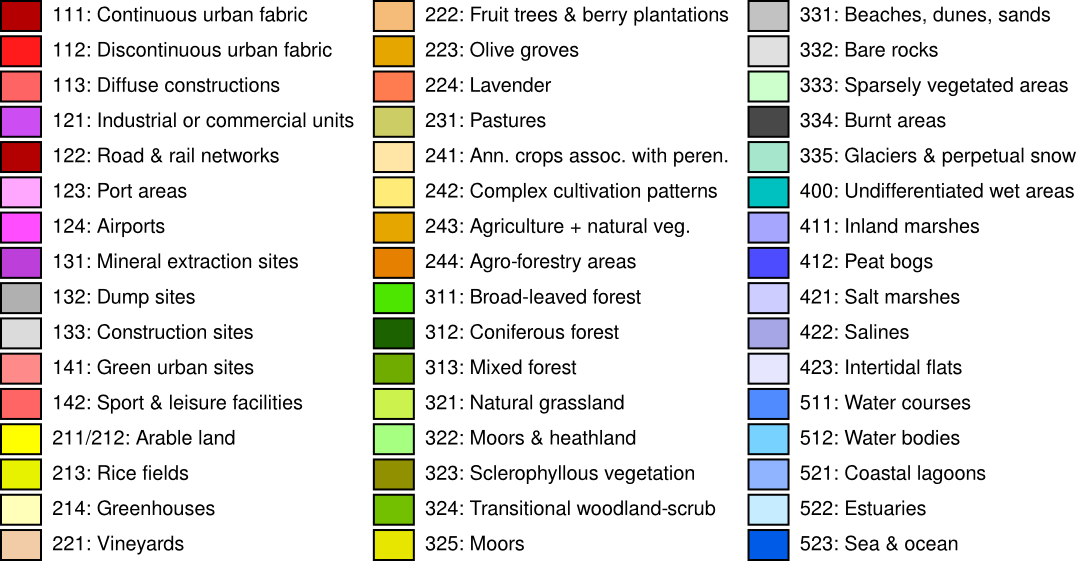

So the first column of our damage curves relates to "111: Continuous urban fabric", and so on. Now let's have a look at the land uses we have within our OSM data. Can you find all the unique values in our 'landuse' column of the **landuse** dataframe?

Our next step would be to attach a value to each of the land-use classes that corresponds to the value of each column (to make sure we have a damage curve linked to each land-use class)

In [115]:
landuse_value_clc = [0, ## complete the list, where each value corresponds to a landuse class in the flood_curves dataframe]

In [116]:
value_dict_clc = dict(zip(landuse.landuse.unique(),landuse_value_clc))
value_dict_clc['nodata'] =  ## add a nodata value
landuse['landuse_value_clc'] = landuse.landuse.apply(lambda x: value_dict_clc[x])

and now rasterize the OSM landuse data again to make it matching!

In [132]:
landuse_clc = make_geocube(
    vector_data= # add landuse,
    output_crs= # add CRS,
    resolution= # add resolution (this should be somewhat similar as the resolution of the flood map),
    categorical_enums={'landuse_value': landuse.landuse_value.drop_duplicates().values.tolist()
}
)

And run the **match_rasters** function now with the new landuse map

In [134]:
landuse_osm_clc, flood_map_osm = match_rasters(# add landuse_clc,
                                           ## add landuse_clc,
                                           haz_crs=3035,
                                           lu_crs=# add landuse CRS,
                                           resolution= #add desired resolution (I would pick the resolution of the flood map),
                                           hazard_col=['band_data'])

And now turn them into numpy arrays again

In [139]:
osm_landuse_map = landuse_osm_clc['band_data'] #complete function
osm_flood_map = flood_map_osm['band_data'] #complete function

And run the DamageScanner

In [ ]:
flood_damage_CLC = DamageScanner(# fill the dammagescanner function)[1]

<div class="alert alert-block alert-success">
<b>Question 13:</b>  How do the results compare to the flood damages estimated with Corine Land Cover? Are you able to visualise the differences?
</div>

## 6. Extracting high-resolution data from OpenStreetMap
<hr>

### Extracting buildings from OpenStreetMap
---

There is a lot more data to extract from OpenStreetMap besides land-use information. Let's extract some building data. To do so, we use the *"building"* tag.

In [60]:
tags = {"building": True}
buildings = ox.features_from_place(place_name, tags)

In case the above does not work, you can continue the assignment by using the code below (make sure you remove the hashtags to run it). If you decide to use the data as specified below, also change the map at the start to 'Kampen'.

In [61]:
# remote_url = https://github.com/VU-IVM/UNIGIS_ProgrammingGIS/tree/main/TAA2'
# file = 'kampen_buildings.gpkg'
#
# #request.urlretrieve(remote_url, file)
# buildings = gpd.GeoDataFrame.from_file('kampen_buildings.gpkg')

Now let's see what information is actually extracted:

In [ ]:
buildings.head()

As you notice in the output of the cell above, there are many columns which just contain "NaN". And there even seem to be to many columns to even visualize properly in one view.

Let's check what information is collected for the different buildings:

In [ ]:
buildings.columns

<div class="alert alert-block alert-success">
<b>Question 14:</b>  Let's have a look at the extracted building information. Please describe in your own words the information it contains. Is there specific information that suprises you to see, and do you think anything is missing that you expected?
</div>

One interesting column is called `start_date`. This shows the building year per building.

Let's explore this year of building a bit more.

First, it would be interesting to get an idea how many buildings are build in each year through using the `value_counts()` function. Normally, that functions ranks the values in descending order (high to low). We are more interested in how this has developed over time. So we use the `sort_index()` function to sort the values by year. Add these two functions in the cell below.

In [64]:
building_year = buildings. #complete function

There is not better way to further explore this years than through plotting it. Don't forget to add things such as a x label, y label and title. Have a look at some of the matplotlib [tutorials](https://matplotlib.org/stable/tutorials/introductory/quick_start.html). Note that you need to look at the code that also uses subplots and where they use the `ax` option. Perhaps also consider setting a threshold to make the figure more easy to visualise?

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(5,18))

building_year.plot(kind='barh',ax=ax)

ax.tick_params(axis='y', which='major', labelsize=7)

<div class="alert alert-block alert-success">
<b>Question 15:</b>  Please upload a figure that shows the development of building stock over the years in your region of interest. Make sure it contains all the necessary elements (labels on the axis, title, etc.)
</div>

What we also noticed is that quite some buildings are identified as 'yes'. This is not very useful as it does not really say much about the use of the building.

Let's see for how many buildings this is the case. Use the .value_counts function:

In [ ]:
buildings.building. #complete function

As you have seen from the `value_counts` function, there are quite a few buildings with only very few tags. You could either consider to not include them in your plot at all (for example by using the `isin` function or the `query` function, see also [here](https://stackoverflow.com/questions/12096252/use-a-list-of-values-to-select-rows-from-a-pandas-dataframe)), or rename them, similar to how you named the natural land cover classes for the land-use map. Here, we filter the dataframe to include only specific classes of buildings.

In [67]:
buildings = buildings[buildings['building'].isin(['yes', 'house', 'industrial', 'apartment'])]

Now let's visualize the buildings again. We need to create a similar color dictionary as we did for the land-use categories. Now its up to you to make it!

In [68]:
color_dict = { 'yes' : "#f1134b",
              'house':'#f13013',
              'industrial':'#0f045c',
              'apartment':'#fcfcb9' }

In [ ]:
map_dict = dict(zip(color_dict.keys(),[x for x in range(len(color_dict))]))
buildings['col_landuse'] =buildings.building.apply(lambda x: color_dict[x])

And plot the figure in the same manner!

In [ ]:
fig, ax = plt.subplots(1, 1,figsize=(12,10))

# add color scheme
color_scheme_map = list(color_dict.values())
cmap = LinearSegmentedColormap.from_list(name='landuse',
                                     colors=color_scheme_map)

# and plot the land-use map.
buildings.plot(color=buildings['col_landuse'],ax=ax,linewidth=0)

# remove the ax labels
ax.set_xticks([])
ax.set_yticks([])
ax.set_axis_off()

# add a legend:
legend_elements = []
for iter_,item in enumerate(color_dict):
    legend_elements.append(Patch(facecolor=color_scheme_map[iter_],label=item))

ax.legend(handles=legend_elements,edgecolor='black',facecolor='#fefdfd',prop={'size':12},loc=(1.02,0.2))

# add a title
ax.set_title(place_name,fontweight='bold')

<div class="alert alert-block alert-success">
<b>Question 16:</b>  Please upload a figure of your building stock map of your region of interest. Make sure that the interpretation is clear. If necessary, merge multiple categories into one (i.e., when some categories only contain 1 or 2 buildings).
</div>

## 7. Perform a damage assessment of the road network using OpenStreetMap
<hr>

Generally, wind damage does not cause much damage to roads. There will be clean-up cost of the trees that will fall on the roads, but structural damage is rare. As such, we will only do a flood damage assessment for the road network of our region.

To do so, we first need to extract the roads again. We will use the `graph_from_place()` function again to do so. However, the area will be to large to extract roads, so we will focus our analysis on the main network.

In [71]:
cf = '["highway"~"trunk|motorway|primary|secondary"]'
G = ox.graph_from_place(place_name, network_type="drive", custom_filter=cf)

Now we convert the road network to a `geodataframe`.

In [72]:
roads = gpd.GeoDataFrame(nx.to_pandas_edgelist(G))
roads.highway = roads.highway.astype('str')

In case the above does not work, you can continue the assignment by using the code below (make sure you remove the hashtags to run it).

In [73]:
#from urllib import request
# remote_url = 'https://github.com/VU-IVM/UNIGIS_ProgrammingGIS/tree/main/TAA2'
# file = 'kampen_roads.gpkg'
#
# #request.urlretrieve(remote_url, file)
# roads = gpd.GeoDataFrame.from_file('kampen_roads.gpkg')

And lets have a look at the data:

In [ ]:
fig, ax = plt.subplots(1, 1,figsize=(12,10))


roads.plot(column='highway',legend=True,ax=ax,legend_kwds={'loc': 'lower right'});


# remove the ax labels
ax.set_xticks([])
ax.set_yticks([])
ax.set_axis_off()

Dependening on the region you have selected, you may have lists in your data. It is actually quite inconvenient to have all these lists in the data for when we want to do the damage assessment. Let's clean this up a bit. To do so, we first make sure that all the lists are represented as actual lists, and not lists wrapped within a string.

In [75]:
roads.highway = roads.highway.apply(lambda x: x.strip('][').split(', '))

Now we just need to grab the first element of each of the lists.

In [76]:
roads.highway = roads.highway.apply(lambda x: x[0] if isinstance(x, list) else x)
roads.highway = roads.highway.str.replace("'","")

And let's have a look whether this worked:

In [ ]:
fig, ax = plt.subplots(1, 1,figsize=(12,10))

roads.plot(column='highway',legend=True,ax=ax,legend_kwds={'loc': 'upper left','ncol':1});

# remove the ax labels
ax.set_xticks([])
ax.set_yticks([])
ax.set_axis_off()

Nice! now let's start with the damage calculation. As you already have may have noticed, our data is now not stored in raster format, but in vector format. One way to deal with this issue is to convert our vector data to raster data, but we will lose a lot of information and detail. As such, we will perform the damage assessment on the road elements, using the xarray flood map.

Let's start with preparing the flood data into vector format:

In [78]:
# get the mean values
flood_map_vector = flood_map_area['band_data'].to_dataframe().reset_index()

# create geometry values and drop lat lon columns
flood_map_vector['geometry'] = [shapely.points(x) for x in list(zip(flood_map_vector['x'],flood_map_vector['y']))]
flood_map_vector = flood_map_vector.drop(['x','y','band','spatial_ref'],axis=1)

# drop all non values to reduce size
flood_map_vector = flood_map_vector.loc[~flood_map_vector['band_data'].isna()].reset_index(drop=True)

# and turn them into squares again:
flood_map_vector.geometry= shapely.buffer(flood_map_vector.geometry,distance=100/2,cap_style='square').values

And let's plot the results:

In [ ]:
gpd.GeoDataFrame(flood_map_vector.copy()).plot(column='band_data',cmap='Blues',vmax=5,linewidth=0)

We will need a bunch of functions to make sure we can do our calculations. They are specified below.

In [80]:
def reproject(df_ds, current_crs="epsg:4326", approximate_crs="epsg:3035"):
    """
    Reproject geometries in a DataFrame from one coordinate reference system (CRS) to another.

    Parameters:
    df_ds : pandas.DataFrame
        A DataFrame containing a 'geometry' column with geometries to reproject.
    current_crs : str or pyproj.CRS, optional
        The current coordinate reference system of the geometries. Default is "epsg:4326".
    approximate_crs : str or pyproj.CRS, optional
        The target coordinate reference system to reproject the geometries into. Default is "epsg:3035".

    Returns:
    shapely.GeometryArray
        A Shapely GeometryArray containing the reprojected geometries.
    """
    geometries = df_ds['geometry']
    coords = shapely.get_coordinates(geometries)
    transformer = pyproj.Transformer.from_crs(current_crs, approximate_crs, always_xy=True)
    new_coords = transformer.transform(coords[:, 0], coords[:, 1])

    return shapely.set_coordinates(geometries.copy(), np.array(new_coords).T)


def buffer_assets(assets, buffer_size=100):
    """
    Create a buffer around each geometry in the assets DataFrame.

    Parameters:
    assets : pandas.DataFrame
        A DataFrame containing a 'geometry' column with geometries to buffer.
    buffer_size : float, optional
        The distance to buffer around each geometry. Default is 100 units.

    Returns:
    pandas.DataFrame
        The input DataFrame with an additional 'buffered' column containing the buffered geometries.
    """
    assets['buffered'] = shapely.buffer(assets.geometry.values, buffer_size)
    return assets


def overlay_hazard_assets(df_ds, assets):
    """
    Find the indices of hazards that overlay or intersect with assets.

    Parameters:
    df_ds : pandas.DataFrame
        A DataFrame containing hazard geometries in a 'geometry' column.
    assets : pandas.DataFrame
        A DataFrame containing asset geometries in a 'geometry' column.

    Returns:
    numpy.ndarray
        An array of indices of hazards that intersect with the assets.
    """
    # Build a spatial index for the hazard geometries
    hazard_tree = shapely.STRtree(df_ds.geometry.values)
    # Determine geometry type of the first asset
    asset_geom_type = shapely.get_type_id(assets.iloc[0].geometry)
    # If the asset geometry is a polygon or multipolygon
    if (asset_geom_type == 3) or (asset_geom_type == 6):
        return hazard_tree.query(assets.geometry, predicate='intersects')
    else:
        # If the asset geometry is not polygon/multipolygon, use buffered geometries
        return hazard_tree.query(assets.buffered, predicate='intersects')


def get_damage_per_asset(asset, df_ds, assets):
    """
    Calculate the total damage for a single asset based on overlapping hazards.

    Parameters:
    asset : tuple
        A tuple containing the asset index and a DataFrame with hazard points intersecting the asset.
    df_ds : pandas.DataFrame
        A DataFrame containing hazard data with a 'geometry' column.
    assets : pandas.DataFrame
        A DataFrame containing asset data with a 'geometry' column.

    Returns:
    tuple
        A tuple containing the asset index and the calculated damage.
    """
    # Find the exact hazard overlays
    get_hazard_points = df_ds.iloc[asset[1]['hazard_point'].values].reset_index()
    # Select hazard points that intersect with the asset geometry
    asset_geom = assets.iloc[asset[0]].geometry
    get_hazard_points = get_hazard_points.loc[shapely.intersects(get_hazard_points.geometry.values, asset_geom)]

    # Parameters for damage calculation
    maxdam_asset = 100  # Maximum damage per asset
    hazard_intensity = np.arange(0, 10, 0.1)  # Hazard intensity levels
    fragility_values = np.arange(0, 1, 0.01)  # Fragility values corresponding to hazard intensity

    if len(get_hazard_points) == 0:
        return asset[0], 0
    else:
        # Calculate the length of the intersection between hazard and asset geometries
        get_hazard_points['overlay_meters'] = shapely.length(
            shapely.intersection(get_hazard_points.geometry.values, asset_geom))
        # Interpolate fragility values based on hazard intensity
        damage = np.sum(
            (np.interp(get_hazard_points.band_data.values, hazard_intensity, fragility_values))
            * get_hazard_points.overlay_meters * maxdam_asset)
        return asset[0], damage

Now we need to make sure that the road data is the same coordinate system.

In [81]:
roads.geometry = reproject(roads)

And we can now overlay the roads with the flood data

In [82]:
overlay_roads = pd.DataFrame(overlay_hazard_assets(flood_map_vector,buffer_assets(roads)).T,columns=['asset','hazard_point'])

And estimate the damages

In [ ]:
collect_output = []
for asset in tqdm(overlay_roads.groupby('asset'),total=len(overlay_roads.asset.unique()),
                              desc='polyline damage calculation for'):
    collect_output.append(get_damage_per_asset(asset,flood_map_vector,roads))

damaged_roads = roads.merge(pd.DataFrame(collect_output,columns=['index','damage']),
                                                          left_index=True,right_on='index')[['highway','geometry','damage']]

<div class="alert alert-block alert-success">
<b>Question 17:</b> Describe the various steps we have taken to perform the damage assessment on the road network. How is this approach different compared to the raster-based approach? Highlight the differences you find most important. Include any line of code you may want to include to make your story clear.
</div>

And let's plot the results

In [ ]:
fig, ax = plt.subplots(1, 1,figsize=(12,10))

damaged_roads.plot(column='damage',cmap='Reds',ax=ax)

<div class="alert alert-block alert-success">
<b>Question 18:</b> Describe the most severely damaged parts of the road network. Use Google Maps to identify these roads. Are you surprised by the results?
</div>